## 1. 📦 Imports & Setup

In [37]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 2. 📁 Dataset Loading & Metadata Parsing

In [44]:
ravdees_speech = "Audio_Speech_Actors_01-24"
ravdees_song =   "Audio_Song_Actors_01-24"

In [45]:
import os
import pandas as pd

# Base directory where RAVDESS data is stored
ravdees_speech = 'Audio_Speech_Actors_01-24'

# Get list of actor folders
ravdees_directory_list = os.listdir(ravdees_speech)

# Initialize lists to store emotions and file paths
file_emotion = []
file_path = []

# Loop through each actor directory
for dir in ravdees_directory_list:
    actor_path = os.path.join(ravdees_speech, dir)
    
    # Skip if not a directory (very safe)
    if not os.path.isdir(actor_path):
        continue

    for file in os.listdir(actor_path):
        # Skip files that are not .wav
        if not file.endswith('.wav'):
            continue

        # Split filename by '-' to extract metadata
        part = file.split('.')[0].split('-')

        # Ensure the filename has enough parts
        if len(part) < 3:
            print(f"Skipping invalid filename: {file}")
            continue

        # Extract emotion code and full path
        try:
            emotion_code = int(part[2])
            full_path = os.path.join(actor_path, file)

            file_emotion.append(emotion_code)
            file_path.append(full_path)
        except ValueError:
            print(f"Non-integer emotion code in: {file}")
            continue

# Create DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

Ravdees_speech_df = pd.concat([emotion_df, path_df], axis=1)

# Replace emotion codes with labels
Ravdees_speech_df.Emotions.replace({
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}, inplace=True)

# Display the result
Ravdees_speech_df.head()


,Emotions,Path
0,neutral,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
1,neutral,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
2,neutral,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
3,neutral,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
4,calm,Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...


In [46]:
import os
import pandas as pd

ravdees_song = 'Audio_Song_Actors_01-24'
ravdees_directory_list1 = os.listdir(ravdees_song)

file_emotion = []
file_path = []

for dir in ravdees_directory_list1:
    actor_path = os.path.join(ravdees_song, dir)
    actor = os.listdir(actor_path)
    for file in actor:
        part = file.split('.')[0].split('-')
        file_emotion.append(int(part[2]))  # emotion code
        full_path = os.path.join(ravdees_song, dir, file)  # ✅ correct path
        file_path.append(full_path)

# Create DataFrame
emotion_df1 = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df1 = pd.DataFrame(file_path, columns=['Path'])

Ravdees_song_df = pd.concat([emotion_df1, path_df1], axis=1)

# Replace emotion codes with labels
Ravdees_song_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

Ravdees_song_df.head()


,Emotions,Path
0,neutral,Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...
1,neutral,Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...
2,neutral,Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...
3,neutral,Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...
4,calm,Audio_Song_Actors_01-24\Actor_01\03-02-02-01-0...


In [47]:
data_path = pd.concat([Ravdees_song_df,Ravdees_speech_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(2452, 2)

In [48]:
# data_path['Path'] = data_path['Path'].str.replace('Audio_Speech_Actors_01-24Actor_', 'Audio_Speech_Actors_01-24/Actor_')

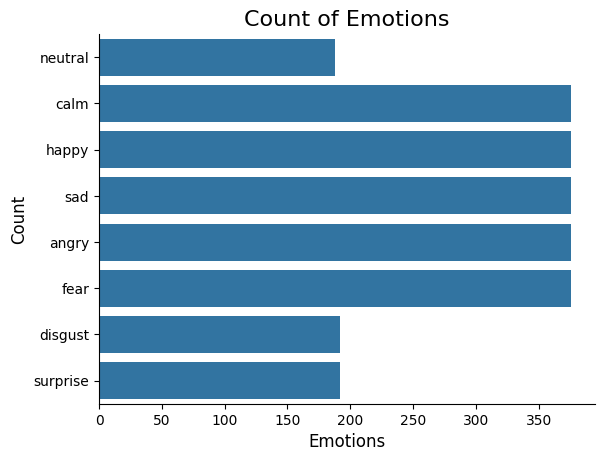

In [49]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [50]:
import matplotlib.pyplot as plt
import librosa.display

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion')
    try:
        librosa.display.waveshow(data, sr=sr)
    except:
        # fallback if waveshow gives error
        time = np.linspace(0, len(data) / sr, num=len(data))
        plt.plot(time, data)
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {e} emotion')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


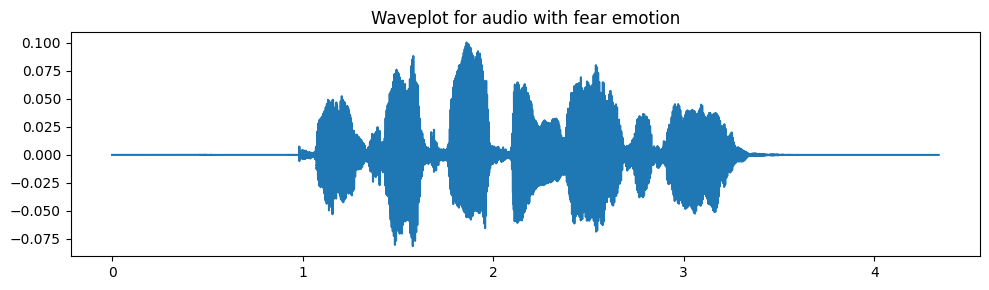

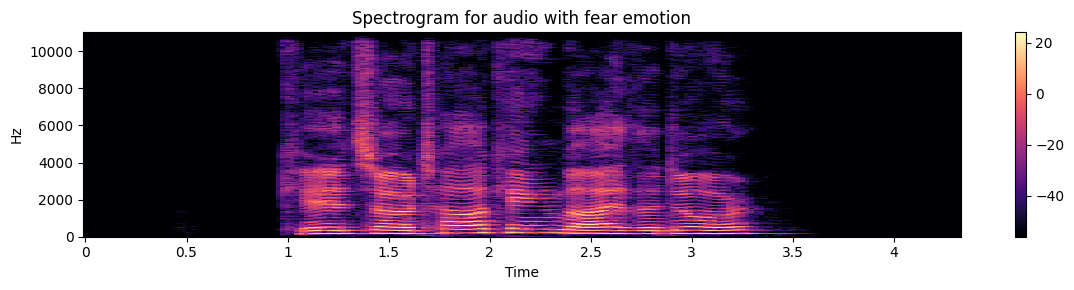

In [51]:
# Load file and plot
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


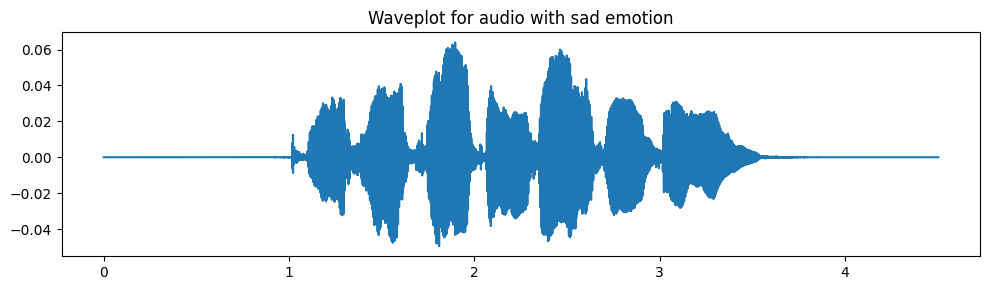

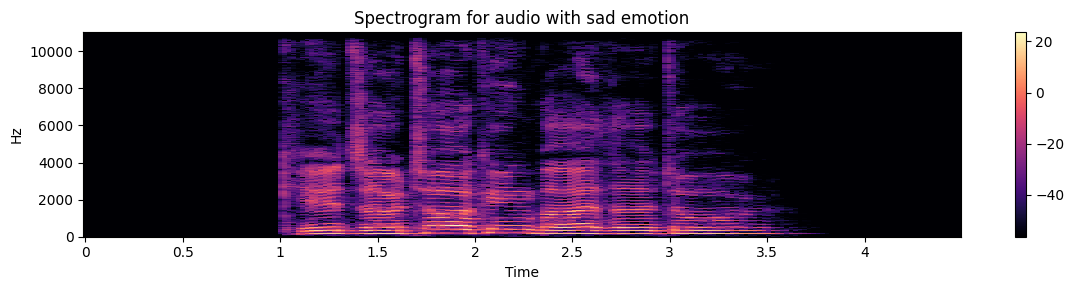

In [52]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [53]:
# Assuming data_path already contains 'Path' and 'Emotions'
data_path.to_csv('original_data_paths.csv', index=False)

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load saved path/label data
data_path = pd.read_csv('original_data_paths.csv')

# Split
train_df, test_df = train_test_split(
    data_path,
    test_size=0.25,
    random_state=42,
    stratify=data_path['Emotions']
)

# Save split sets
train_df.to_csv('train_paths.csv', index=False)
test_df.to_csv('test_paths.csv', index=False)


## 3. ✂️ Train-Test Split (Before Augmentation)

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load saved path/label data
data_path = pd.read_csv('original_data_paths.csv')

# Split
train_df, test_df = train_test_split(
    data_path,
    test_size=0.25,
    random_state=42,
    stratify=data_path['Emotions']
)

# Save split sets
train_df.to_csv('train_paths.csv', index=False)
test_df.to_csv('test_paths.csv', index=False)


## 4. 🎛️ Audio Augmentations (Only on Training Set)

In [59]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# def pitch(data, sampling_rate, pitch_factor=0.7):
#     return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [60]:
# Load train set only
import pandas as pd
train_df = pd.read_csv("train_paths.csv")

# Try augmentation on 1 sample from training set
path = train_df.Path.iloc[0]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

# Apply augmentations
data_noise = noise(data)
data_shift = shift(data)
data_pitch = pitch(data, sample_rate)


## 5. 🎚️ Feature Extraction

In [61]:
def extract_features(data, sample_rate):
    result = np.array([])

    # 1. Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # 2. Chroma STFT
    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))

    # 3. MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # 4. Delta MFCC
    delta_mfcc = np.mean(librosa.feature.delta(mfcc).T, axis=0)
    result = np.hstack((result, delta_mfcc))

    # 5. RMS Energy
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # 6. Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    # 7. Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, centroid))

    # 8. Spectral Bandwidth
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, bandwidth))

    # # 9. Spectral Contrast
    # contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, contrast))

    # # 10. Tonnetz (requires harmonic signal)
    # try:
    #     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sample_rate).T, axis=0)
    #     result = np.hstack((result, tonnetz))
    # except:
    #     pass  # Some very short or non-harmonic audio may fail

    return result


In [62]:
def process_audio_file(path, label, augment=False):
    features, labels = [], []
    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    features.append(extract_features(data, sr))
    labels.append(label)

    if augment:
        features.append(extract_features(noise(data), sr))
        labels.append(label)

        features.append(extract_features(shift(data), sr))
        labels.append(label)

        features.append(extract_features(pitch(data, sr), sr))
        labels.append(label)

    return features, labels


In [63]:
def build_dataset(train_csv, test_csv):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    X_train, y_train = [], []
    X_test, y_test = [], []

    for _, row in train_df.iterrows():
        try:
            feats, labels = process_audio_file(row['Path'], row['Emotions'], augment=True)
            X_train.extend(feats)
            y_train.extend(labels)
        except Exception as e:
            print(f"⚠️ Skipping training file {row['Path']} due to error: {e}")

    for _, row in test_df.iterrows():
        try:
            feats, labels = process_audio_file(row['Path'], row['Emotions'], augment=False)
            X_test.extend(feats)
            y_test.extend(labels)
        except Exception as e:
            print(f"⚠️ Skipping test file {row['Path']} due to error: {e}")

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)


In [71]:
def preprocess(X_train, y_train, X_test, y_test):
    encoder = OneHotEncoder(sparse_output=False)
    y_train_enc = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_enc  = encoder.transform(y_test.reshape(-1, 1))

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    X_train_final = np.expand_dims(X_train_scaled, axis=2)
    X_test_final  = np.expand_dims(X_test_scaled, axis=2)

    return X_train_final, y_train_enc, X_test_final, y_test_enc


In [65]:
X_train, y_train, X_test, y_test = build_dataset("train_paths.csv", "test_paths.csv")
X_train_final, y_train_enc, X_test_final, y_test_enc = preprocess(X_train, y_train, X_test, y_test)

print("✅ X_train:", X_train_final.shape)
print("✅ y_train:", y_train_enc.shape)
print("✅ X_test :", X_test_final.shape)
print("✅ y_test :", y_test_enc.shape)


✅ X_train: (7356, 165, 1)
✅ y_train: (7356, 8)
✅ X_test : (613, 165, 1)
✅ y_test : (613, 8)


## 7. 🧠 Model Building & Training

In [35]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

**CNN ARCHITECTURE**

In [66]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train_final.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 165, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 83, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 83, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 42, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 42, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)        

In [67]:
# # 🔁 Clear the previous model
# from tensorflow.keras import backend as K
# K.clear_session()

In [68]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
history=model.fit(X_train_final, y_train_enc, batch_size=64, epochs=50, validation_data=(X_test_final, y_test_enc), callbacks=[rlrp])

Epoch 1/50


115/115 [==============================] - 51s 422ms/step - loss: 1.8636 - accuracy: 0.2533 - val_loss: 1.7306 - val_accuracy: 0.3393 - lr: 0.0010
Epoch 2/50
115/115 [==============================] - 48s 415ms/step - loss: 1.6613 - accuracy: 0.3403 - val_loss: 1.5261 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 3/50
115/115 [==============================] - 47s 404ms/step - loss: 1.5155 - accuracy: 0.4012 - val_loss: 1.5156 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 4/50
115/115 [==============================] - 49s 427ms/step - loss: 1.4245 - accuracy: 0.4459 - val_loss: 1.3599 - val_accuracy: 0.4959 - lr: 0.0010
Epoch 5/50
115/115 [==============================] - 52s 447ms/step - loss: 1.3427 - accuracy: 0.4774 - val_loss: 1.2852 - val_accuracy: 0.4927 - lr: 0.0010
Epoch 6/50
115/115 [==============================] - 49s 424ms/step - loss: 1.2547 - accuracy: 0.5068 - val_loss: 1.2517 - val_accuracy: 0.5302 - lr: 0.0010
Epoch 7/50
115/115 [==============================

## 8. 📊 Evaluation

In [69]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [74]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train_enc = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_enc = encoder.transform(y_test.reshape(-1, 1))


In [75]:
#predicting on test data.
pred_test = model.predict(X_test_final)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test_enc)

20/20 [==============================] - 0s 13ms/step


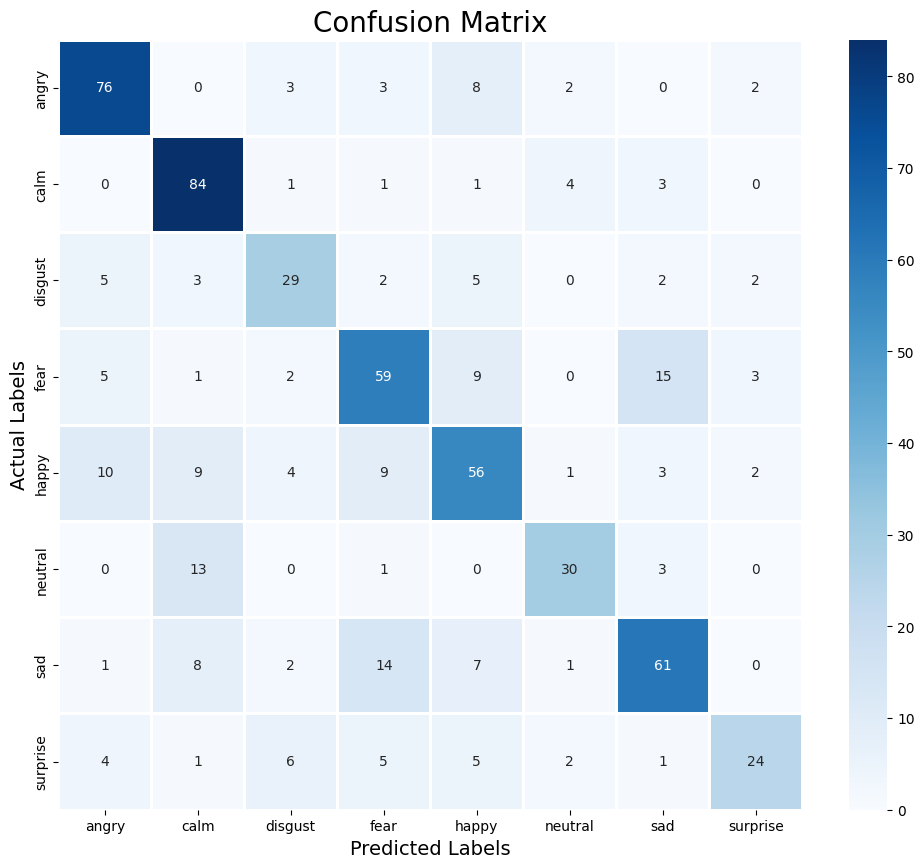

In [76]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.81      0.78        94
        calm       0.71      0.89      0.79        94
     disgust       0.62      0.60      0.61        48
        fear       0.63      0.63      0.63        94
       happy       0.62      0.60      0.61        94
     neutral       0.75      0.64      0.69        47
         sad       0.69      0.65      0.67        94
    surprise       0.73      0.50      0.59        48

    accuracy                           0.68       613
   macro avg       0.69      0.66      0.67       613
weighted avg       0.68      0.68      0.68       613



In [78]:
from tensorflow.keras.models import load_model

# Save model
model.save("model.h5")
